In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [100]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [102]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device=device):
        super(VAE, self).__init__()

        # encoder - THIS CAN BE MESSED AROUND WITH
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)
        
        # decoder - THIS CAN ALSO BE MESSED AROUND WITH
        self.point_decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim)
            )
        
        # CLASS decoder - THIS CAN ALSO BE MESSED AROUND WITH. This is to decode (predict) whether the pt is in collision or not.
        self.label_decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1), # just decoding 1 thing here: collision or not
            nn.Sigmoid() # make the prediction a probability
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    #def decode(self, x):
    #    return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        #x_hat = self.decode(z)
        x_hat = self.point_decoder(z)
        x_hat[2] = sigmoid(x_hat[2])
        x_hat[0] = (sigmoid(x_hat[0]) - 0.5)*2*math.pi
        x_hat[1] = (sigmoid(x_hat[1]) - 0.5)*2*math.pi
        #label_hat = self.label_decoder(z)
        return x_hat, mean, logvar

In [19]:
model = VAE(3,3,2)
model(train_data[0:2])

(tensor([[ 0.6010,  0.3273, -0.4814],
         [ 0.6849,  0.2926, -0.5046]], grad_fn=<AddmmBackward0>),
 tensor([[-0.3423,  0.0722],
         [-0.3417,  0.0729]], grad_fn=<AddmmBackward0>),
 tensor([[-0.2230, -0.2775],
         [-0.2224, -0.2779]], grad_fn=<AddmmBackward0>))

In [3]:
def is_collision_free(x,y):
    columns = []
    columns.append(((-math.pi/2 - 0.2, -math.pi/2 + 0.2),(-0.1,0.1)))
    columns.append(((-0.2, 0.2),(-1.1,-0.9)))
    columns.append(((math.pi/2 - 0.2, math.pi/2 + 0.2),(0.9,1.1)))
    if x <= -math.pi or x > math.pi or y <= -math.pi or y > math.pi:
        raise Exception("point needs to be in [-pi,pi] x [-pi,pi]")
    for column in columns:
        in_x_col = x >= column[0][0] and x <= column[0][1]
        in_y_op = y > column[1][0] and y < column[1][1]
        if in_x_col and not in_y_op:
            return False
    return True

In [4]:
torch.isinf(torch.tensor(float('inf')))

tensor(True)

In [93]:
def loss_function(x, x_hat, mean, log_var, alpha = 1, beta = 1):
    # alpha and beta are parameters to determine how much to weight Euclidean distance and correct classification
    
    for i in range(len(x_hat)):
        if i < len(x_hat) - 1:
            if x_hat[i] > math.pi or x_hat[i] <= -math.pi:
                return 1e6
        else:
            if x_hat[i] < 0 or x_hat[i] > 1:
                return 1e6
    
    # Euclidean reconstruction loss
    dist = torch.sqrt(torch.sum((x_hat - x)**2)) # Euclidean distance
    reconstruction_loss = alpha*dist
    
    # BCE label loss
    #label = is_collision_free(x) # or label(x)
    #pred = COLLISIONCHECKER(x_hat)
    
    # need probabilities that it is collision and not collision. So we need a collision predictor
    # IDEA: make the COLLISIONCHECKER function a neural network classifier so that we can backprop.
    
    #label_loss = beta*nn.functional.binary_cross_entropy(label, label_hat, reduction='sum')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    #return reconstruction_loss + label_loss + KLD
    return torch.tensor(reconstruction_loss + KLD)

In [6]:
is_collision_free(2.5,3)

True

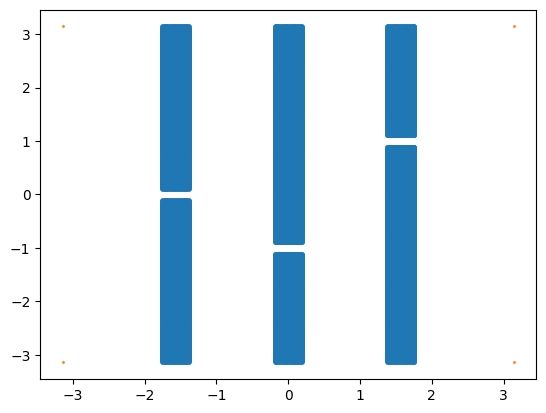

In [7]:
num_samples = 500

x_values = [ math.pi * (n/num_samples) - math.pi * (1-n/num_samples) for n in range(1,num_samples+1)]
y_values = x_values
value_grid = []
for y in y_values:
    y_section = [(x,y,is_collision_free(x,y)) for x in x_values]
    value_grid.append(y_section)

x_collisions = []
y_collisions = []
for y_row in value_grid:
    for entry in y_row:
        if not entry[2]:
            x_collisions.append(entry[0])
            y_collisions.append(entry[1])
plt.scatter(x_collisions, y_collisions, s =5)
plt.scatter([-3.1415,-3.1415, 3.1415,3.1415], [-3.1415,3.1415,-3.1415,3.1415], s = 1)

In [8]:
len(value_grid[0])

500

In [9]:
train_data = [value_grid[i][j] for i in range(500) for j in range(500)]
train_data = torch.tensor(train_data)

In [10]:
train_data.shape

torch.Size([250000, 3])

In [13]:
for elt in enumerate(train_data):
    print(elt)
    break

(0, tensor([-3.1290, -3.1290,  1.0000]))


In [14]:
batch_size = 1000

In [15]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)

In [16]:
for batch_idx, batch in enumerate(train_loader):
    print(batch_idx, batch)
    break

0 tensor([[ 2.1237,  2.7520,  1.0000],
        [-0.5278,  0.6786,  1.0000],
        [-1.3195,  2.3876,  1.0000],
        ...,
        [-1.5834, -0.5655,  0.0000],
        [ 2.0358, -1.7844,  1.0000],
        [ 1.6211,  2.9782,  0.0000]])


In [89]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss_float = 0.
        for batch_idx, batch in enumerate(train_loader):
            #x = x.view(batch_size, x_dim).to(device)
            
            optimizer.zero_grad()
            
            batch_output = model(batch)

            x_hats, means, log_vars = batch_output[0], batch_output[1], batch_output[2] 
            loss = torch.tensor(0.)
            for i in range(batch_size):
                x_hat, mean, log_var = x_hats[i], means[i], log_vars[i]
                loss += loss_function(batch[i], x_hat, mean, log_var)
                #print(type(loss))
            
            overall_loss_float += loss
            
        overall_loss = torch.tensor(overall_loss_float, requires_grad = True)
        overall_loss.backward()
        optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [90]:
torch.tensor(0.).requires_grad

False

In [103]:
model = VAE(3,3,2)
optimizer = Adam(model.parameters(), lr=1e-1)
train(model, optimizer, epochs=5, device=device)

ValueError: only one element tensors can be converted to Python scalars

In [96]:
batch[0], model(batch[0])

(tensor([-2.6515, -2.8777,  1.0000]),
 (tensor([0.1925, 0.6315, 0.1759], grad_fn=<ViewBackward0>),
  tensor([ 0.0796, -0.4391], grad_fn=<ViewBackward0>),
  tensor([-0.1793, -0.1845], grad_fn=<ViewBackward0>)))

In [ ]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

# Attempt with Autoencoder (non-variational)?